# Project 02 #

## Anisotropic Diffusion ##

Due: November 12th at 11:59 PM

By: Shane Houghton and Richie Glennon

In [3]:
# Common imports
import numpy as np
import skimage.io as io
import matplotlib.pylab as plt
plt.gray() # set default to grayscale

<Figure size 432x288 with 0 Axes>

Anisotropic Diffusion (Perona–Malik diffusion) is an edge preserving noise reduction method. It is an iterative process similar to the blind deconvolution project. The main portion of the process is equation 1 which uses the ESF in equation 2. The process is repeated niter number of times.

Equations source:

https://www.sciencedirect.com/science/article/pii/S147466701642210X


$\begin{gather}
I_{s}^{t+1} \approx I_{s}^{t} +\frac{\lambda }{|\eta _{s} |}\sum g\left( |\triangledown I_{s,p}^{t} |, \gamma \right) \triangledown I_{s,p}^{t}\tag{1}\\
\end{gather}$


$\begin{gather}
g( x,\gamma ) =\ \left\{\left[ 1-\left( x^{2} /5\gamma ^{2}\right)\right]^{2} \ where\ |x|\ \leq \ \gamma \sqrt{5} ,\ 0\ otherwise\ \right\}\tag{2}\\
\end{gather}$

In [37]:
def anisotropic_diffusion(im, gam, lam, n, niter=10):
    """
    Performs anisotropic diffusion on the given image
    Parameters
    ----------
    * im - the input image to be diffused
    * gam - gamma: Constant to control the speed of diffusion. should not exceed 1/7 
    * lam - lambda: 
    * niter (optional) - number of iterations 

    Returns
    -------
    imout - the diffused image

    """
    def g(x,y):
        """
        ESF - edge stopping function
        """
        if abs(np.sum(x) <= y * np.sqrt(5)):
            return (1 - (x**2/5*y**2))**2
        else:
            return 0

    for i in range(niter):
        if i == 0:
            imlast = np.zeros((im.shape[0], im.shape[1]))
        gradient = im - imlast
        imout = im + (lam/n) * np.sum(g((gradient), gam) * gradient)
        imlast = im
        im = imout
    return imout

    # What is Ns and how do we compute lambda / Ns
    # Is N neighborhood? (adjacent)
    # How do we do piecewise condition in G?
    # Do we need to do for each pixel in the image (pixel s to pixel p)
    # Generic filter?
    # Is this on the right track?
    # Do you understand the math and can help explain?
    # lines are absolute values? Why abs on N
    # Any simpler way to do this?    

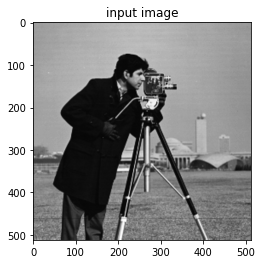

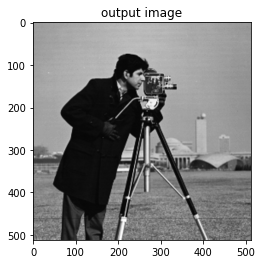

In [38]:
im = io.imread("cameraman.tif")
plt.imshow(im)
plt.title("input image")
out = anisotropic_diffusion(im, 0.1, 1, 8, niter=100)
plt.figure()
plt.title("output image")
plt.imshow(out)